In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [330]:
hp = pd.read_excel('Online Retail.xlsx')

In [331]:
hp.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [332]:
hp.shape

(541909, 8)

In [333]:
#keep only UK data
rtl=hp[hp['Country']=='United Kingdom'].reset_index(drop=True)

In [334]:
rtl.shape

(495478, 8)

In [335]:
rtl.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [336]:
rtl.dropna(inplace=True)

In [337]:
rtl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      361878 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


In [338]:
rtl['CustomerID']=rtl['CustomerID'].astype(str)

In [339]:
rtl=rtl[rtl['Quantity']>0]

In [340]:
rtl['Price']=rtl['Quantity']*rtl['UnitPrice']

In [341]:
import datetime as datetime
## Convert to datetime to proper datatype

rtl['InvoiceDate'] = pd.to_datetime(rtl['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [342]:
max_date=rtl['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:49:00')

In [343]:
#calculate gap between recency and transaction date
rtl['Gap']=max_date-rtl['InvoiceDate']

In [344]:
rtl.head()

InvoiceNo StockCode  ...  Price               Gap
0    536365    85123A  ...  15.30 373 days 04:23:00
1    536365     71053  ...  20.34 373 days 04:23:00
2    536365    84406B  ...  22.00 373 days 04:23:00
3    536365    84029G  ...  20.34 373 days 04:23:00
4    536365    84029E  ...  20.34 373 days 04:23:00

[5 rows x 10 columns]

create RFM model


In [345]:
#Create Recency model
RFM_R=rtl.groupby('CustomerID')['Gap'].min().reset_index()

In [346]:
RFM_R

CustomerID               Gap
0       12346.0 325 days 02:48:00
1       12747.0   1 days 22:15:00
2       12748.0   0 days 00:29:00
3       12749.0   3 days 02:53:00
4       12820.0   2 days 21:37:00
...         ...               ...
3916    18280.0 277 days 02:57:00
3917    18281.0 180 days 01:56:00
3918    18282.0   7 days 01:06:00
3919    18283.0   3 days 00:47:00
3920    18287.0  42 days 03:20:00

[3921 rows x 2 columns]

In [347]:
RFM_R['Gap']=RFM_R['Gap'].dt.days

In [348]:
#Create Frequency attributes
RFM_F=rtl.groupby('CustomerID')['InvoiceNo'].count().reset_index()
    


In [349]:
#create moneytary attributes
RFM_M=rtl.groupby('CustomerID')['Price'].sum().reset_index()

In [350]:
RFM_F.head()

CustomerID  InvoiceNo
0    12346.0          1
1    12747.0        103
2    12748.0       4596
3    12749.0        199
4    12820.0         59

In [351]:
rfm = pd.merge(RFM_M, RFM_F, on='CustomerID', how='inner')
rfm.head()

CustomerID     Price  InvoiceNo
0    12346.0  77183.60          1
1    12747.0   4196.01        103
2    12748.0  33719.73       4596
3    12749.0   4090.88        199
4    12820.0    942.34         59

In [352]:
RFM_R.head()

CustomerID  Gap
0    12346.0  325
1    12747.0    1
2    12748.0    0
3    12749.0    3
4    12820.0    2

In [353]:
rfm=pd.merge(rfm, RFM_R, on='CustomerID', how='inner')


In [354]:
rfm.columns = ['CustomerID', 'Price', 'Frequency', 'Recency']

In [355]:
rfm.head()

CustomerID     Price  Frequency  Recency
0    12346.0  77183.60          1      325
1    12747.0   4196.01        103        1
2    12748.0  33719.73       4596        0
3    12749.0   4090.88        199        3
4    12820.0    942.34         59        2

In [356]:
rfm.Recency.describe()

count    3921.000000
mean       91.188472
std        99.528995
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

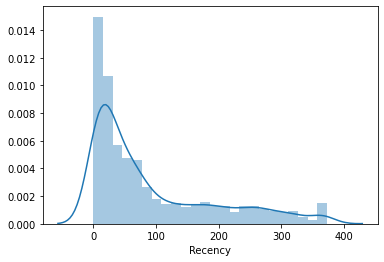

In [357]:
#recency Distribusion plot
sns.distplot(rfm.Recency)

In [358]:
rfm.Frequency.describe()

count    3921.000000
mean       90.371079
std       217.796155
min         1.000000
25%        17.000000
50%        41.000000
75%        99.000000
max      7847.000000
Name: Frequency, dtype: float64

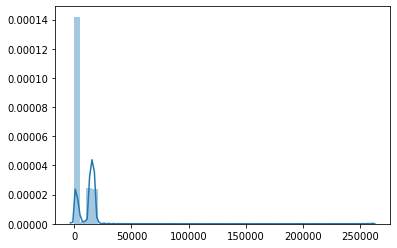

In [359]:
#Frequency Distribusion plot
sns.distplot(rfm[rfm['Frequency']<1000])


In [360]:
rfm.Price.describe()

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: Price, dtype: float64

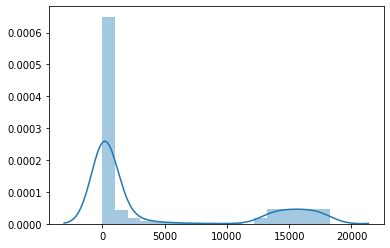

In [361]:
sns.distplot(rfm[rfm['Price']<15000])

In [362]:
#split into customer segment using quantiles
quantiles=rfm.quantile(q=[0.25,0.5,0.75])
quantiles=quantiles.to_dict()

In [363]:
quantiles

{'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Price': {0.25: 300.03999999999996,
  0.5: 651.8200000000002,
  0.75: 1575.8900000000003},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0}}

In [364]:
#create R,F,M segments
def rfm_RSeg(x,p,d):
    if x<=d[p][0.25]:
        return 1
    elif x<=d[p][0.5]:
        return 2
    elif x<=d[p][0.75]:
        return 3
    else:
        return 4
    

    

In [365]:
def rfm_FMSeg(x,p,d):
    if x<=d[p][0.25]:
        return 4
    elif x<=d[p][0.5]:
        return 3
    elif x<=d[p][0.75]:
        return 2
    else:
        return 1


In [366]:
rfm['R'] = rfm['Recency'].apply(rfm_RSeg, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(rfm_FMSeg, args=('Frequency',quantiles,))
rfm['M'] = rfm['Price'].apply(rfm_FMSeg, args=('Price',quantiles,))
rfm.head()
    

CustomerID     Price  Frequency  Recency  R  F  M
0    12346.0  77183.60          1      325  4  4  1
1    12747.0   4196.01        103        1  1  1  1
2    12748.0  33719.73       4596        0  1  1  1
3    12749.0   4090.88        199        3  1  1  1
4    12820.0    942.34         59        2  1  2  2

In [367]:
rfm.R.value_counts()

1    1025
4     976
3     962
2     958
Name: R, dtype: int64

In [368]:
#rfm group value column for concatenate the combined individual score
rfm['rfm_group']=rfm.R.map(str)+rfm.F.map(str)+rfm.M.map(str)

In [369]:
rfm['rfm_score']=rfm['R']+rfm['F']+rfm['M']

In [370]:
rfm.head()

CustomerID     Price  Frequency  Recency  R  F  M rfm_group  rfm_score
0    12346.0  77183.60          1      325  4  4  1       441          9
1    12747.0   4196.01        103        1  1  1  1       111          3
2    12748.0  33719.73       4596        0  1  1  1       111          3
3    12749.0   4090.88        199        3  1  1  1       111          3
4    12820.0    942.34         59        2  1  2  2       122          5

In [371]:
#create loyaliy level
loyalty_level=['platinum','Gold','Silver','Bzonze']
score_cuts=pd.qcut(rfm.rfm_score, q= 4, labels=loyalty_level)
rfm['RFM_loyal_level']=score_cuts.values
rfm.reset_index().head()

index CustomerID     Price  ...  rfm_group  rfm_score  RFM_loyal_level
0      0    12346.0  77183.60  ...        441          9           Silver
1      1    12747.0   4196.01  ...        111          3         platinum
2      2    12748.0  33719.73  ...        111          3         platinum
3      3    12749.0   4090.88  ...        111          3         platinum
4      4    12820.0    942.34  ...        122          5         platinum

[5 rows x 11 columns]

In [372]:
rfm[rfm['rfm_group']=='111'].sort_values('Price',ascending=False).reset_index().head(15)

index CustomerID      Price  ...  rfm_group  rfm_score  RFM_loyal_level
0    3784    18102.0  259657.30  ...        111          3         platinum
1    3315    17450.0  194550.79  ...        111          3         platinum
2    3357    17511.0   91062.38  ...        111          3         platinum
3    2767    16684.0   66653.56  ...        111          3         platinum
4     903    14096.0   65164.79  ...        111          3         platinum
5     621    13694.0   65039.62  ...        111          3         platinum
6    1772    15311.0   60767.90  ...        111          3         platinum
7     191    13089.0   58825.83  ...        111          3         platinum
8    2110    15769.0   56252.72  ...        111          3         platinum
9    1580    15061.0   54534.14  ...        111          3         platinum
10   1045    14298.0   51527.30  ...        111          3         platinum
11    898    14088.0   50491.81  ...        111          3         platinum
12   3594    17841.0   40991.57  ...        111          3         platinum
13    694    13798.0   37153.85  ...        111          3         platinum
14   2281    16013.0   37130.60  ...        111          3         platinum

[15 rows x 11 columns]

In [373]:
graph = rfm.query("Price < 50000 and Frequency < 2000")


In [374]:
def cat_level(x):
    if x=='platinum':
        return 1
    elif x=='Gold':
        return 2
    elif x=='Silver':
        return 3
    else:
        return 4
    
graph['RFM_loyal_level']=graph['RFM_loyal_level'].map(cat_level)

In [375]:
import plotly.figure_factory as ff


In [376]:
import plotly.graph_objects as go

In [377]:
x=graph['Price']
y=graph['Frequency']
z=graph['Recency']   
a=graph['RFM_loyal_level']
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=8,
        color=a,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        showscale=True
         ),
    
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()



In [378]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_data(x):
    if x<=0:
        return 1
    else:
        return x



In [379]:
rfm['Price'] = rfm['Price'].map(handle_data)
rfm['Recency'] = rfm['Recency'].map(handle_data)

In [380]:
#Perform Log transformation to bring data into normal or near normal distribution
rfm_lg = rfm[['Recency', 'Frequency', 'Price']].apply(np.log, axis = 1).round(3)

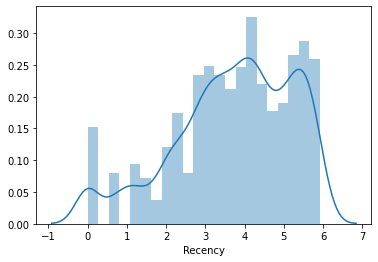

In [381]:
#distribution plot for Recency
sns.distplot(rfm_lg.Recency)

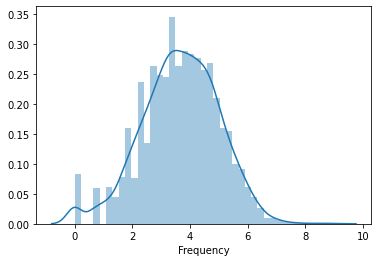

In [382]:
#distribution plot for Frequency
sns.distplot(rfm_lg.Frequency)

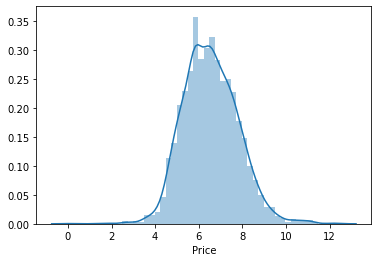

In [383]:
#dist plot for Price
sns.distplot(rfm_lg.Price)

In [384]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
rfm_lg=scaler.fit_transform(rfm_lg)

In [385]:
rfm_lg_data=pd.DataFrame(rfm_lg,index=rfm.index,columns=['Price','Frequency','Recency'])

In [386]:
rfm_lg_data

Price  Frequency   Recency
0     1.375709  -2.733639  3.766415
1    -2.448913   0.726978  1.439009
2    -2.448913   3.562667  3.104639
3    -1.722209   1.218258  1.419028
4    -1.990673   0.311106  0.244935
...        ...        ...       ...
3916  1.269910  -1.014157 -1.075421
3917  0.984915  -1.280702 -1.718015
3918 -1.162137  -0.878270 -1.086610
3919 -1.722209   2.215005  0.883533
3920  0.022808   0.438033  0.778831

[3921 rows x 3 columns]

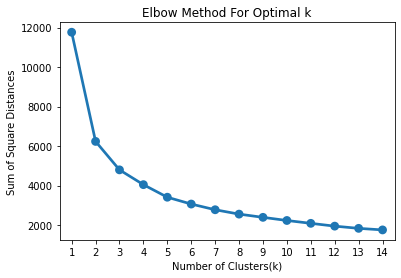

In [387]:
from sklearn.cluster import KMeans
SSD={}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(rfm_lg_data)
    SSD[k] = km.inertia_


#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(SSD.keys()), y = list(SSD.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [388]:
#clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(rfm_lg_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [389]:
#make data set with cluster
rfm['Cluster']=KMean_clust.labels_
rfm.head()

CustomerID     Price  Frequency  ...  rfm_score  RFM_loyal_level  Cluster
0    12346.0  77183.60          1  ...          9           Silver        0
1    12747.0   4196.01        103  ...          3         platinum        1
2    12748.0  33719.73       4596  ...          3         platinum        1
3    12749.0   4090.88        199  ...          3         platinum        1
4    12820.0    942.34         59  ...          5         platinum        1

[5 rows x 11 columns]

In [390]:
rfm.Cluster.value_counts()

0    1658
2    1425
1     838
Name: Cluster, dtype: int64

In [316]:
x=rfm['Price']
y=rfm['Frequency']
z=rfm['Recency']   
a=rfm['Cluster']
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=a,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        showscale=True
         ),
    
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


In [391]:
#apply DBScan clustering
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=3,min_samples=4)
db.fit(rfm_lg_data)

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=4, n_jobs=None, p=None)

In [392]:
rfm_lg_data

Price  Frequency   Recency
0     1.375709  -2.733639  3.766415
1    -2.448913   0.726978  1.439009
2    -2.448913   3.562667  3.104639
3    -1.722209   1.218258  1.419028
4    -1.990673   0.311106  0.244935
...        ...        ...       ...
3916  1.269910  -1.014157 -1.075421
3917  0.984915  -1.280702 -1.718015
3918 -1.162137  -0.878270 -1.086610
3919 -1.722209   2.215005  0.883533
3920  0.022808   0.438033  0.778831

[3921 rows x 3 columns]

In [393]:

rfm['Cluster_DBS'] = db.labels_


In [394]:
rfm.Cluster_DBS.value_counts()

0    3921
Name: Cluster_DBS, dtype: int64

In [395]:
x=rfm['Price']
y=rfm['Frequency']
z=rfm['Recency']   
a=rfm['Cluster_DBS']
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=10,
        color=a,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        showscale=True
         ),
    
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


In [412]:
#DBScan returns 1 cluster only,the density in our data is not that strong.Performed better for a bigger data.

In [400]:
#lets try with Hierarchical Clustering.
from sklearn.cluster import AgglomerativeClustering 

agglom = AgglomerativeClustering(n_clusters=3, linkage='average').fit(rfm_lg_data)
rfm['Cluster_Agl'] = agglom.labels_


In [401]:
x=rfm['Price']
y=rfm['Frequency']
z=rfm['Recency']   
a=rfm['Cluster_Agl']
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=10,
        color=a,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        showscale=True
         ),
    
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


In [402]:
rfm['Cluster_Agl'].value_counts()

0    3904
2      16
1       1
Name: Cluster_Agl, dtype: int64

In [404]:
#
from sklearn.cluster import MeanShift, estimate_bandwidth
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(rfm_lg_data, quantile=0.1)
ms = MeanShift(bandwidth).fit(rfm_lg_data)
rfm['Cluster_MnSf'] = ms.labels_

In [405]:
x=rfm['Price']
y=rfm['Frequency']
z=rfm['Recency']   
a=rfm['Cluster_MnSf']
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=10,
        color=a,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        showscale=True
         ),
    
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


In [406]:
rfm['Cluster_MnSf'].value_counts()

0     3322
7      290
1      192
4       58
8       22
6       20
2       10
9        3
5        2
3        1
10       1
Name: Cluster_MnSf, dtype: int64

In [407]:
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

dist = distance_matrix(rfm_lg_data, rfm_lg_data)
print(dist)

[[0.         5.65865861 7.39656335 ... 5.78229211 6.51131171 4.56240029]
 [5.65865861 0.         3.28868631 ... 3.25750923 1.74667686 2.57463212]
 [7.39656335 3.28868631 0.         ... 6.2405358  2.69770351 4.61325546]
 ...
 [5.78229211 3.25750923 6.2405358  ... 0.         3.70991888 2.57227941]
 [6.51131171 1.74667686 2.69770351 ... 3.70991888 0.         2.49272482]
 [4.56240029 2.57463212 4.61325546 ... 2.57227941 2.49272482 0.        ]]


In [408]:
Z = hierarchy.linkage(dist, 'complete')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



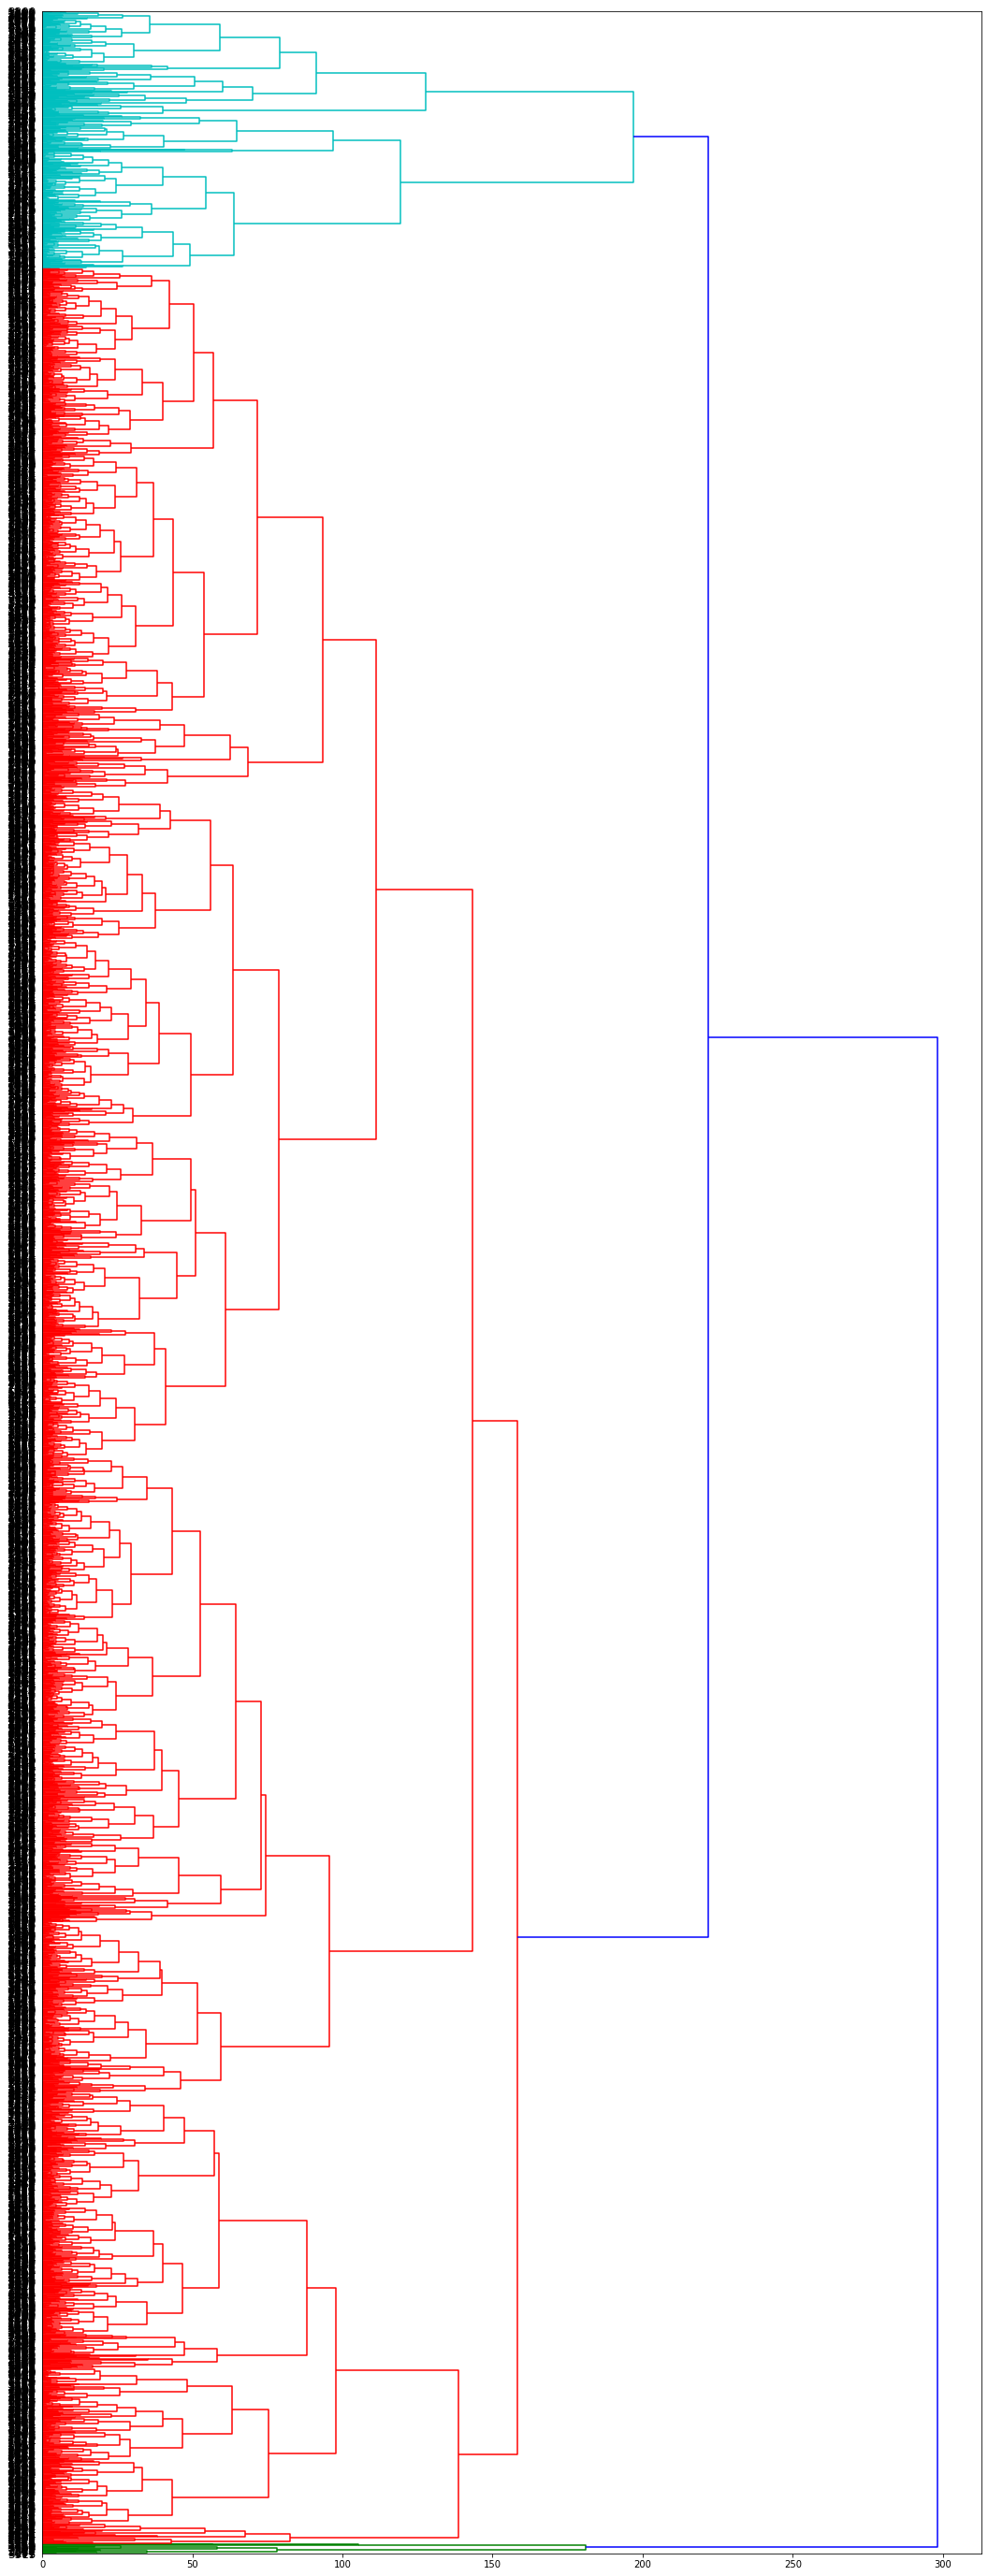

In [409]:
plt.figure(figsize=(18, 50))
dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size=12, orientation='right')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



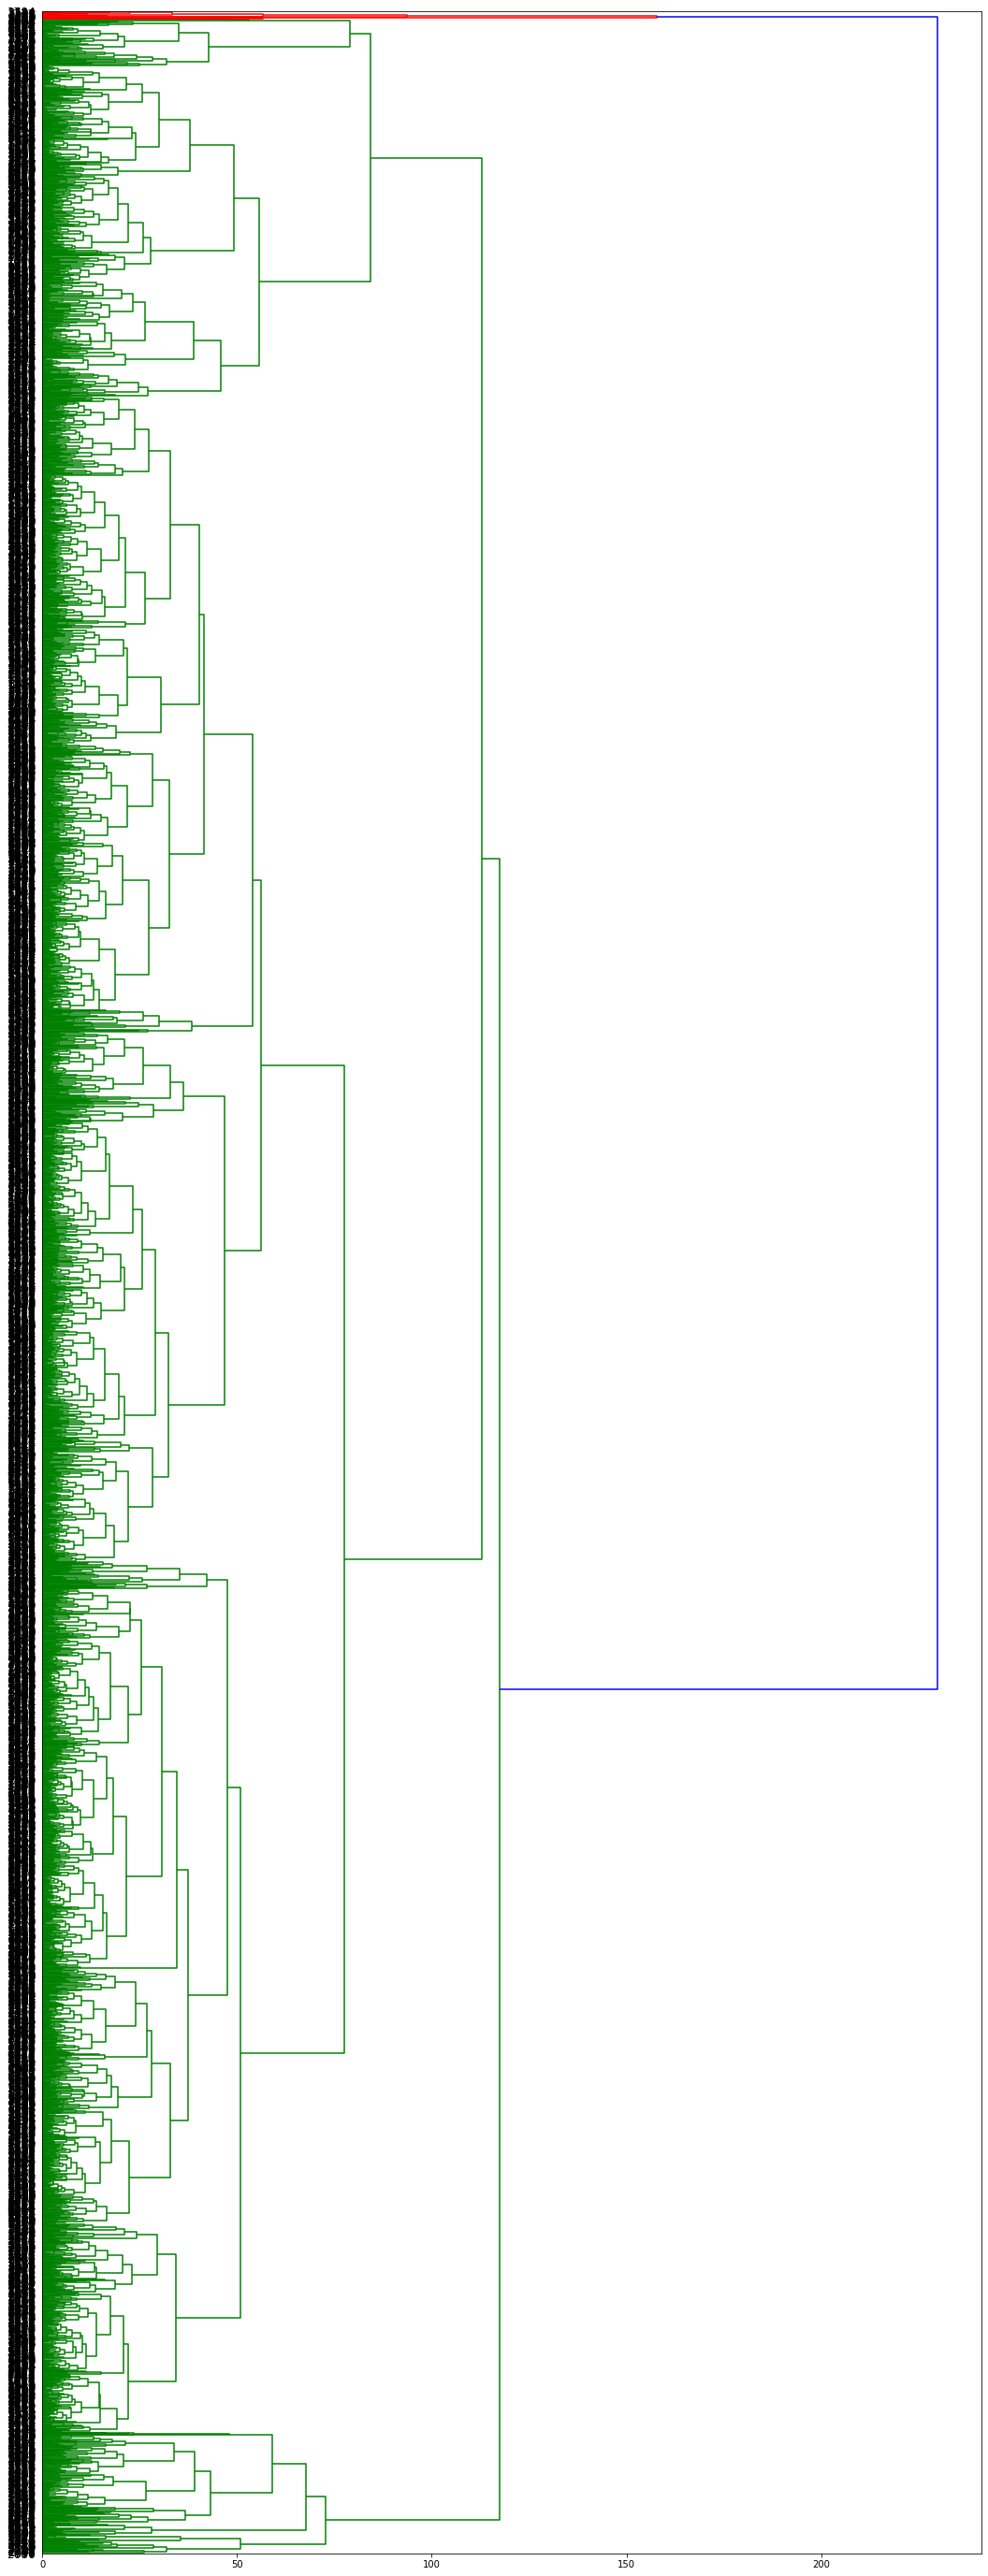

In [411]:
#We used complete linkage for our case, let's change it to average linkage to see how the dendogram changes.
Z1 = hierarchy.linkage(dist, 'average')
plt.figure(figsize=(18, 50))
dendro = hierarchy.dendrogram(Z1, leaf_rotation=0, leaf_font_size =12, orientation = 'right')